In [1]:
import numpy as np
from sklearn import datasets
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('life_expectancy.csv')

data_arr = np.array(df.iloc[:]).T[3:-1].T.astype(np.float64)


In [4]:
new_data_arr = []
for data in data_arr:
  if np.sum(data) == np.sum(data):
    new_data_arr.append(data)

new_data_arr = np.array(new_data_arr)

new_data_arr_norm = new_data_arr / np.mean(new_data_arr, axis = 0)
p = np.random.permutation(len(new_data_arr_norm))
new_data_arr_norm = new_data_arr_norm[p]

In [5]:
tr_data = new_data_arr_norm[0:1200]
print(np.mean(tr_data))
ts_data = new_data_arr_norm[1200:]
print(np.mean(ts_data))

1.0121915638716523
0.9674167557995944


In [6]:
tr_data_x = torch.from_numpy(tr_data.T[1:-1].T.astype(np.float32))
tr_data_y = torch.from_numpy(np.expand_dims(tr_data.T[0].T, axis = -1).astype(np.float32))

print(tr_data_x)
print(tr_data_y)


ts_data_x = torch.from_numpy(ts_data.T[1:-1].T.astype(np.float32))
ts_data_y = torch.from_numpy(np.expand_dims(ts_data.T[0].T, axis = -1).astype(np.float32))

tensor([[1.6645e-01, 4.6079e+01, 3.0222e-01,  ..., 7.9296e+01, 5.5869e+00,
         5.7052e+00],
        [8.6199e-01, 0.0000e+00, 2.0074e-01,  ..., 1.6125e-02, 3.0924e-01,
         2.8526e-01],
        [1.8429e-01, 1.2902e+00, 3.5295e-01,  ..., 1.3597e+00, 1.8142e+00,
         1.7931e+00],
        ...,
        [4.9936e-01, 3.0719e-02, 1.8706e+00,  ..., 1.2685e-03, 1.8554e-01,
         1.6301e-01],
        [1.3316e+00, 0.0000e+00, 1.2750e+00,  ..., 1.0371e-02, 1.4843e+00,
         1.4671e+00],
        [2.1401e-01, 9.5229e-01, 4.1913e-02,  ..., 1.3425e-02, 1.8348e+00,
         1.7931e+00]])
tensor([[0.9350],
        [1.0245],
        [0.8311],
        ...,
        [1.1284],
        [0.9206],
        [0.8138]])


In [7]:
#2 layer BNN 
num_features = 16
regression_out=1

priomu=-1.00000000e-01
priosig=2.00000000e-02

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=priomu, prior_sigma=priosig, in_features=num_features, out_features=128),
    nn.Tanh(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.01, in_features=128, out_features=regression_out),
    #nn.Tanh(),
)

In [8]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
kl_weight = 0.1

In [10]:
mse_per_iteration=[]
kl_per_iteration=[]
cost_arr=[]

for step in range(3000):
    pre = model(tr_data_x)
    mse = mse_loss(pre,tr_data_y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    mse_per_iteration.append(mse.item())
    kl_per_iteration.append(kl.item())
    cost_arr.append(cost.item())
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 0.03, KL : 0.04


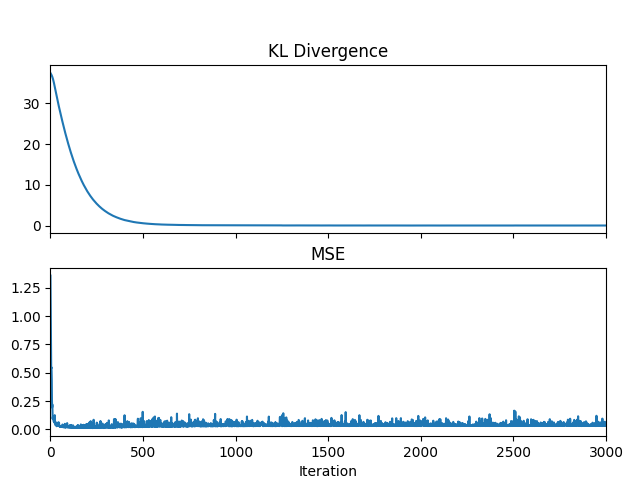

In [11]:
fig, axs = plt.subplots(2,sharex=True)
fig.suptitle(' ')
fig.tight_layout(pad=1.5)
axs[0].plot(kl_per_iteration)
axs[0].set_title('KL Divergence')
axs[1].plot(mse_per_iteration)
axs[1].set_title('MSE')
axs[1].set(xlabel='Iteration')

plt.xlim([0, 3000])

for ax in axs:
    ax.label_outer()

Text(0.5, 1.0, 'Moving STD of MSE')

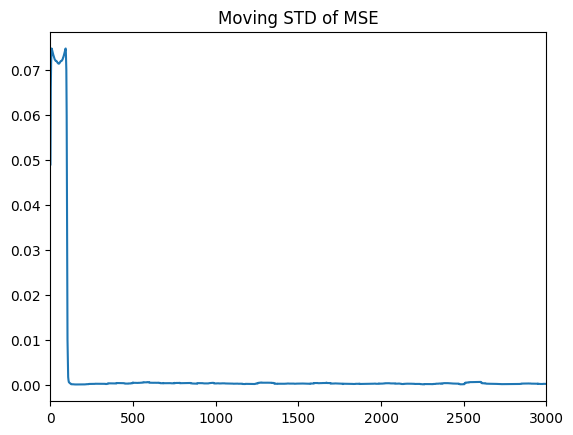

In [12]:
def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

mse_np=np.array(mse_per_iteration)

a = np.var(rolling_window(mse_np, 100), axis=-1)

plt.xlim([0, 3000])

plt.plot(a)
plt.title(label="Moving STD of MSE")

In [13]:
np.sum((((model(ts_data_x)-ts_data_y)*69.3).detach().numpy())**2)/len(ts_data_y)

383.1888223830735

In [14]:
np.std(ts_data_y.detach().numpy()*69.3)

9.036927

0.12591182


(array([  9.,  43.,  54., 110.,  90.,  46.,  35.,  30.,  20.,  12.]),
 array([-0.28017998, -0.18841039, -0.0966408 , -0.00487121,  0.08689837,
         0.17866796,  0.27043754,  0.36220714,  0.45397672,  0.54574633,
         0.6375159 ]),
 <BarContainer object of 10 artists>)

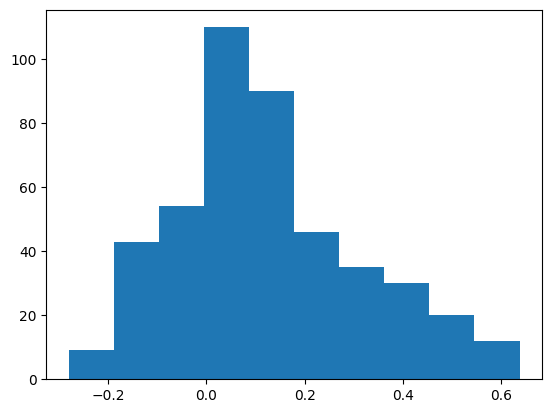

In [15]:
acc=((model(ts_data_x)-ts_data_y))
acc=acc.detach().numpy()
print(np.mean(acc))
plt.hist(acc)

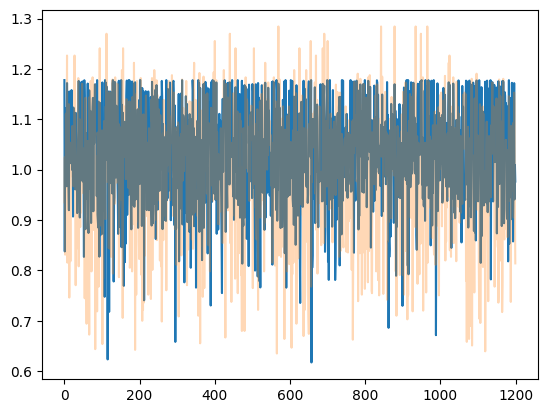

In [16]:
trrx=model(tr_data_x).detach().numpy()
trry=tr_data_y.detach().numpy()

plt.plot(trrx)
plt.plot(trry,alpha=0.3)

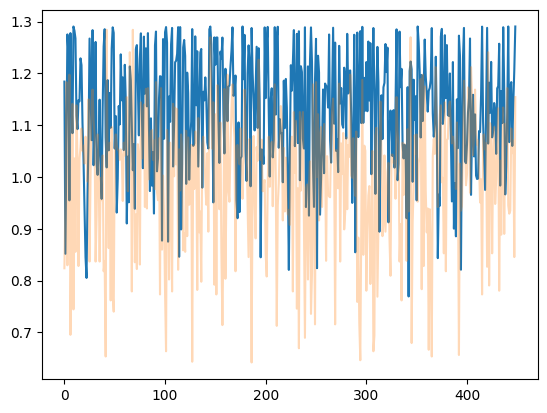

In [24]:
tssx=model(ts_data_x).detach().numpy()
tssy=ts_data_y.detach().numpy()

plt.plot(tssx)
plt.plot(tssy,alpha=0.3)

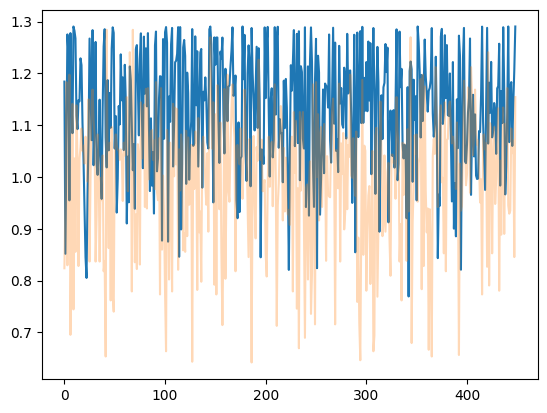

In [ ]:
tssx=model(ts_data_x).detach().numpy()
tssy=ts_data_y.detach().numpy()

plt.plot(tssx)
plt.plot(tssy,alpha=0.3)

In [18]:
'''
num_features = 16
regression_out=1
mid_layer=32
acc_vec=[]

for var_1 in range(10):
    for mean_1 in range(10):   
        meaninter=-0.5+(mean_1/10)
        #print(meaninter)
        variter=0.01+(var_1/100)
        model = nn.Sequential(-1.00000000e-01
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=regression_out),
            #nn.Tanh(),
        )
        mse_per_iteration=[]
        kl_per_iteration=[]
        cost_arr=[]

        for step in range(3000):
            pre = model(tr_data_x)
            mse = mse_loss(pre,tr_data_y)
            kl = kl_loss(model)
            cost = mse + kl_weight*kl
            mse_per_iteration.append(mse.item())
            kl_per_iteration.append(kl.item())
            cost_arr.append(cost.item())    
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))
        #2 layer BNN 
        acc=((model(ts_data_x)-ts_data_y))
        acc=acc.detach().numpy()
        print(np.std(acc),variter,meaninter)
        acc_vec.append([np.std(acc),variter,meaninter,mse.item(), kl.item()])


'''
    

"\nnum_features = 16\nregression_out=1\nmid_layer=32\nacc_vec=[]\n\nfor var_1 in range(10):\n    for mean_1 in range(10):   \n        meaninter=-0.5+(mean_1/10)\n        #print(meaninter)\n        variter=0.01+(var_1/100)\n        model = nn.Sequential(-1.00000000e-01\n            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=regression_out),\n            #nn.Tanh(),\n        )\n        mse_per_iteration=[]\n        kl_per_iteration=[]\n        cost_arr=[]\n\n        for step in range(3000):\n            pre = model(tr_data_x)\n            mse = mse_loss(pre,tr_data_y)\n            kl = kl_loss(model)\n            cost = mse + kl_weight*kl\n            mse_per_iteration.append(mse.item())\n            kl_per_iteration.append(kl.item())\n            cost_arr.append(cost.item())    \n            optimizer.zero_grad()\n            cost.backward()\n            optimizer.step()\n\n        print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))\n        #2 la

In [19]:
arr=np.array(acc_vec)
print(np.shape(arr))

np.argmin(arr,axis=0)

print(arr[14])
arr[:,0]




NameError: name 'acc_vec' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


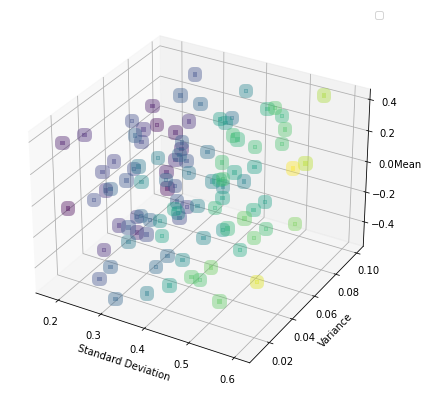

In [ ]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(projection='3d')

ax.scatter(arr[:,0],arr[:,1],arr[:,2],alpha=0.4,c=arr[:,0],marker='s',linewidths=10)
#ax.plot(x_b,y_b,z_rl,"ro",alpha=0.5,color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)

ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Variance")
ax.set_zlabel("Mean")


# Optimal stddev 1.77822843e-01 
# Optimal variance 2.00000000e-02 
# Optimal mean -1.00000000e-01 



plt.legend()

plt.show()